In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
data = pd.read_csv("/content/Churn_Modelling.csv")

In [4]:
X = data.drop("Exited", axis=1)
y = data["Exited"]

In [5]:
cat_features = X.select_dtypes(include=['object', 'category']).columns
num_features = X.select_dtypes(include=['int64', 'float64']).columns

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
}

In [10]:
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1593
           1       0.51      0.20      0.29       407

    accuracy                           0.80      2000
   macro avg       0.66      0.57      0.58      2000
weighted avg       0.76      0.80      0.76      2000

ROC-AUC: 0.7563449427856207

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.85      0.98      0.92      1593
           1       0.85      0.35      0.49       407

    accuracy                           0.85      2000
   macro avg       0.85      0.67      0.70      2000
weighted avg       0.85      0.85      0.83      2000

ROC-AUC: 0.8423400287807068

--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.48      0.59       407

    accuracy                           0.86    

In [11]:
results = {}
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    results[name] = roc_auc_score(y_test, y_proba)

print("Model ROC-AUC Comparison:")
for name, score in results.items():
    print(f"{name}: {score:.3f}")

Model ROC-AUC Comparison:
Logistic Regression: 0.756
Random Forest: 0.842
Gradient Boosting: 0.867


<Axes: title={'center': 'Top 10 Important Features'}>

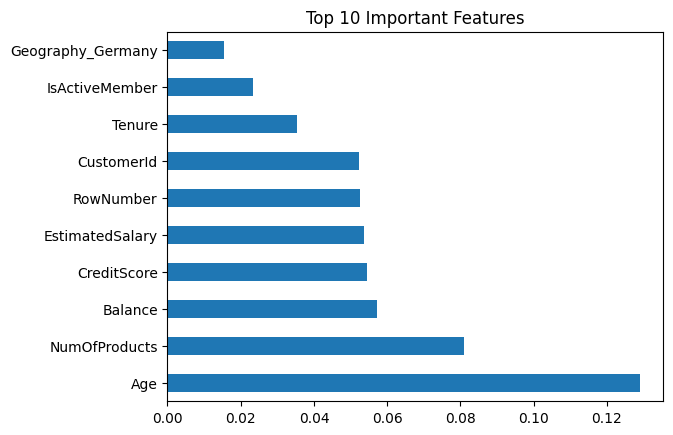

In [12]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf)])
rf_pipeline.fit(X_train, y_train)

# Extract feature names
encoded_features = rf_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_features)
all_features = np.concatenate([num_features, encoded_features])

# Feature importance
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False).head(10)

feat_imp.plot(kind='barh', title="Top 10 Important Features")